# Support points with Exponential Mechanism

### Procedure:


1. Given data $X = \{x_1, \ldots, x_M\}$ on space $\mathcal{D} \in [0, 1]^d$, find optimal support points $Y = \{y_1, \ldots, y_N\}$.
2. Using energy distance (with Lp norm) as the score function of the exponential mechanism, the sensitivity is $\Delta f = \frac{2 d^{1/p}(2N - 1)}{N^2}$. The exponential mechanism samples a new energy value $\tilde{e} \sim \mbox{Exp}(\frac{2\Delta f}{\alpha})$, where $\alpha$ is the privacy budget.
3. Let $\tilde{Y}$ be a copy of $Y$. While $e(\tilde{Y}, Y) < \tilde{e}$, perturb all points in $\tilde{Y}$ with small step in a random direction.


_____

# 0. Helper Functions

In [1]:
%matplotlib inline

import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pdb
from scipy.spatial.distance import pdist
import sys
import tensorflow as tf
import time

from sp_utils import (
    get_support_points,
    energy,
    sample_sp_exp_mech,
    mixture_model_likelihood,
    sample_full_set_by_diffusion)

plt.style.use('ggplot')
print(sys.version)
print(tf.__version__)

3.7.1 (default, Nov 28 2018, 11:55:14) 
[Clang 9.0.0 (clang-900.0.39.2)]
1.13.1


____

# 1. Global Config

In [2]:
# Set global constants.          # main1()
IS_TF = True                     # Boolean. Use TensorFlow rather than analytical gradients.
Y_INIT_OPTION = 'radial'         # ['grid', 'random', 'radial']
DATA_SOURCE = 'balog'            # ['balog', 'gaussian', 'gamma', 'beta']
MAX_ITER = 301                   # Num iterations in each support point optimization. [301]
LR = 1e-2                        # Energy optimization learning rate. [1e-2]

ENERGY_POWER = 2.                # Power for energy distance kernel.
ALPHA = 10                        # Differential privacy level.
M = 100                          # Number of data points.
N = 10                            # Number of support points.
DIM = 2                          # Dimension of data.
STEP_SIZE = 1e-3                 # Diffusion and MH step sizes.
NUM_Y_TILDES = 500               # Number of samples of support points.

___

# 2. Load and Plot Data

In [3]:
if DATA_SOURCE == 'balog':
    os.system('python data.py {} {}'.format(M, DIM))
    
    # Note that Balog's N is our M.
    DATA_PATH = '../data/mixture_of_Gaussians_N{}_D{}.npz'. format(M, DIM)

Loaded M=100 data points with dimension DIM=2


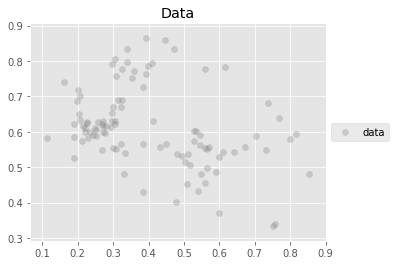

In [4]:
# Load data.
if DATA_SOURCE == 'balog':
    data = np.load(DATA_PATH)
    x = data['X_private']
    mus = data['MUS']
    weights = data['WEIGHTS']
    sigma_data = data['SIGMA_DATA']
    assert (M, DIM) == np.shape(x), 'Balog data dims do not match global params.'
    print('Loaded M={} data points with dimension DIM={}'.format(M, DIM))
    plt.scatter(x[:, 0], x[:, 1], c="gray", alpha=0.3,
                label='data')
    #plt.scatter(mus[:, 0], mus[:, 1], c='green', alpha=1, s=700*weights,
    #            label='true centroids')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Data')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

___

# 3. Run Support Point Optimization

is_tf: True, y_init: radial, clip: bounds, weights: False

  [*] Using TensorFlow optimization.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
  [*] Overall it/s: 0.0082


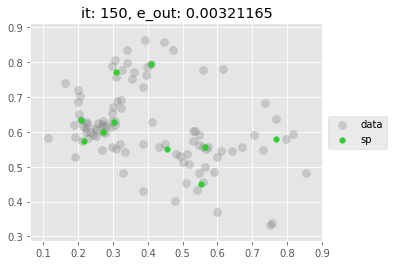

  [*] Overall it/s: 0.0097


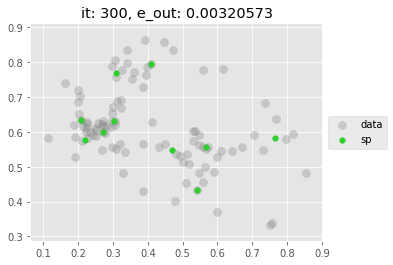

In [5]:
# Compute m support points on full set.
y_opt, e_opt = get_support_points(x, N, MAX_ITER, LR, is_tf=IS_TF)

___

# 4. Define sensitivity.

In [6]:
# Define energy sensitivity for Exponential Mechanism.
# OLD: energy_sensitivity = 2 * DIM ** (1. / ENERGY_POWER) / N ** 2
energy_sensitivity = 2 * DIM ** (1. / ENERGY_POWER) * (2 * N - 1) / N ** 2
print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
       '= Exp({:.3f})').format(energy_sensitivity, ALPHA, 
                               2. * energy_sensitivity / ALPHA))

Exp(2 * U / alpha) = Exp(2 * 0.5374 / 10.00) = Exp(0.107)


___

# 5. Sample support points.



--------- RUNNING DIFFUSION ----------


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.5374 / 10.000) = Exp(0.1075)

Diffusion count 40507, e_opt:  0.003206, e~: 0.110693, energy(y,y~): 0.111133, error%: 0.003971


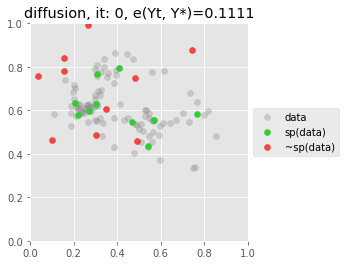

In [7]:
# Sampling parameters.
STEP_SIZE = 1e-3
NUM_Y_TILDES = 1

RUN_MH = 0
RUN_DIFFUSION = 1
PLOT = 1

if RUN_MH:
    METHOD = 'mh'
    print('\n\n--------- RUNNING {} ----------\n'.format(METHOD.upper()))
    (y_tildes_mh,
     energies_mh) = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt,
                                       METHOD, STEP_SIZE, NUM_Y_TILDES, 
                                       alpha=ALPHA)

if RUN_DIFFUSION:
    METHOD = 'diffusion'
    print('\n\n--------- RUNNING {} ----------\n'.format(METHOD.upper()))
    (y_tildes_diffusion,
     energies_diffusion) = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt,
                                              METHOD, STEP_SIZE, NUM_Y_TILDES,
                                              alpha=ALPHA)

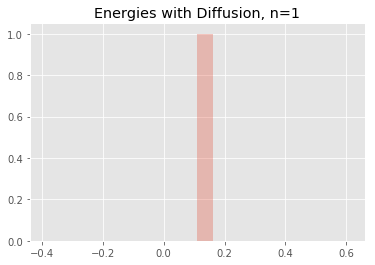

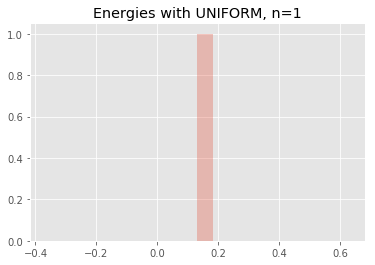

In [8]:
# Plot results of sampling for private support points.
if PLOT:
    if RUN_MH:
        plt.title('Energies with MH, n={}'.format(len(energies_mh)))
        plt.hist(energies_mh, bins=20, alpha=0.3)
        plt.show()

    if RUN_DIFFUSION:
        plt.title('Energies with Diffusion, n={}'.format(len(energies_diffusion)))
        plt.hist(energies_diffusion, bins=20, alpha=0.3)
        plt.show()

    # Compare to energies of e(y_opt, uniform)
    baseline_energies = np.zeros(NUM_Y_TILDES)
    for i in range(NUM_Y_TILDES):
        e_, _ = energy(y_opt, np.random.uniform(size=y_opt.shape))
        baseline_energies[i] = e_
    plt.title('Energies with UNIFORM, n={}'.format(len(baseline_energies)))
    plt.hist(baseline_energies, bins=20, alpha=0.3)
    plt.show()

___

# 6. Expand to full data set.

### 6.0  Given privately sampled (by diffusion) SP, expand them using KDE and pre-selected bandwidth.


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.5374 / 10.000) = Exp(0.1075)

Diffusion count  1380, e_opt:  0.003206, e~: 0.032235, energy(y,y~): 0.032613, error%: 0.011700


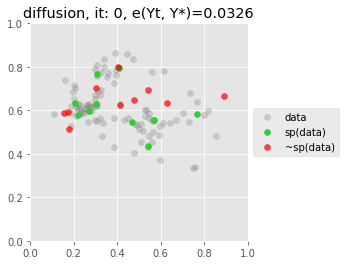

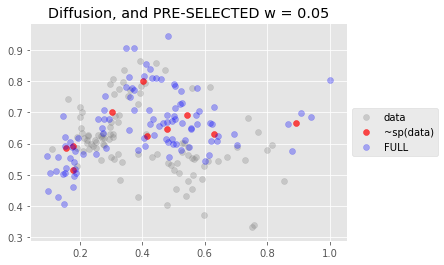

In [ ]:
# Show data and y_tilde.
NUM_Y_TILDES = 1
METHOD = 'diffusion'
BANDWIDTH = 0.05
FULL_SAMPLE_SIZE = M
STEP_SIZE = 2e-3

(y_tilde,
 y_tilde_upsampled,
 y_tilde_expansion,
 energy_y_y_tilde) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
                                                  x, y_opt, STEP_SIZE, ALPHA,
                                                  BANDWIDTH, FULL_SAMPLE_SIZE, 
                                                  plot=True)

###  6.1  Show KDE over a range of bandwidths, and compute likelihood for each.

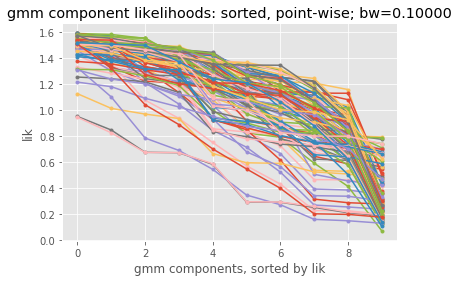

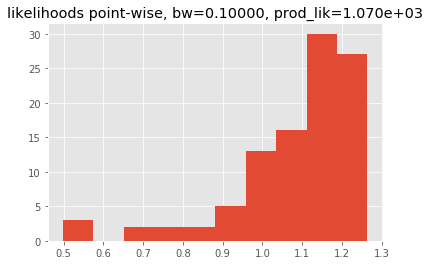

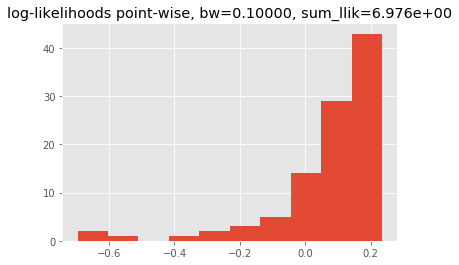

prod_liks=1.070e+03, log_prod_lik=6.976e+00, sum_llik=6.976e+00




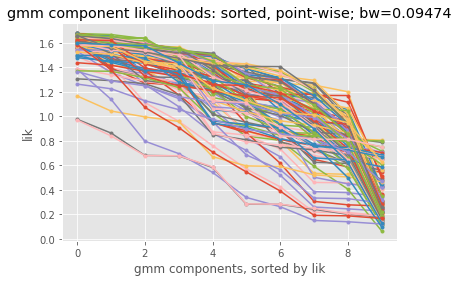

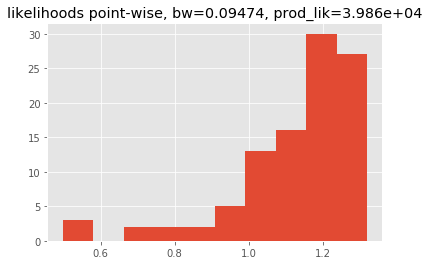

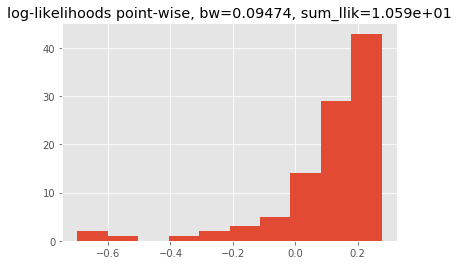

prod_liks=3.986e+04, log_prod_lik=1.059e+01, sum_llik=1.059e+01




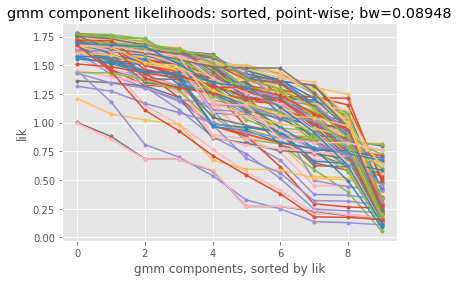

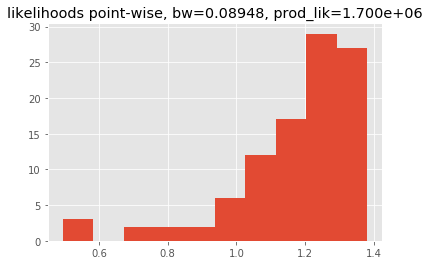

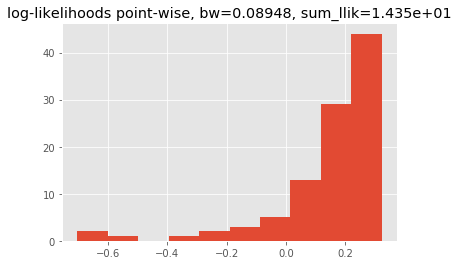

prod_liks=1.700e+06, log_prod_lik=1.435e+01, sum_llik=1.435e+01




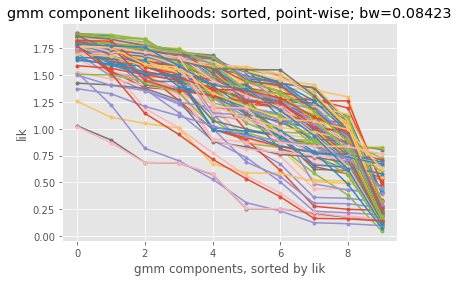

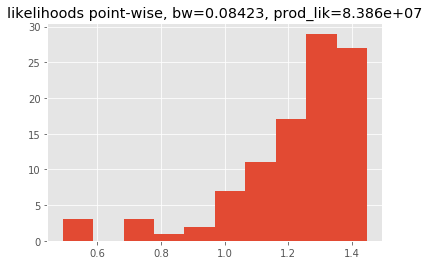

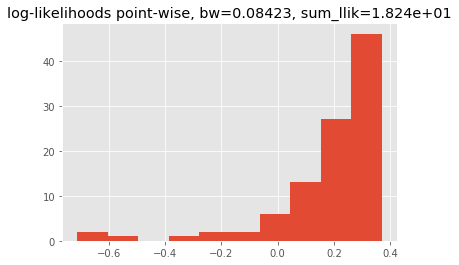

prod_liks=8.386e+07, log_prod_lik=1.824e+01, sum_llik=1.824e+01




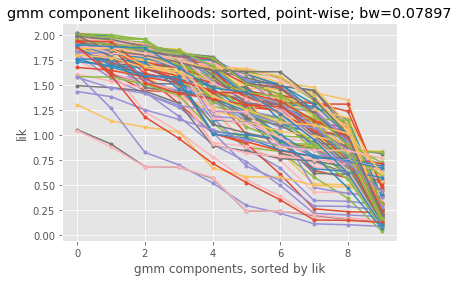

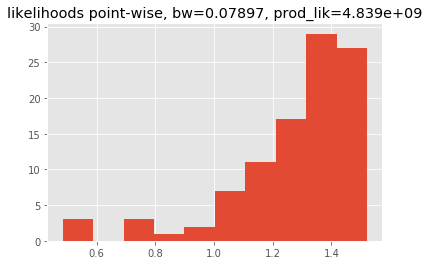

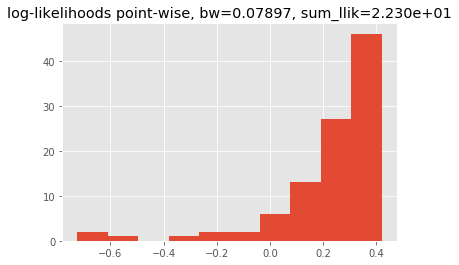

prod_liks=4.839e+09, log_prod_lik=2.230e+01, sum_llik=2.230e+01




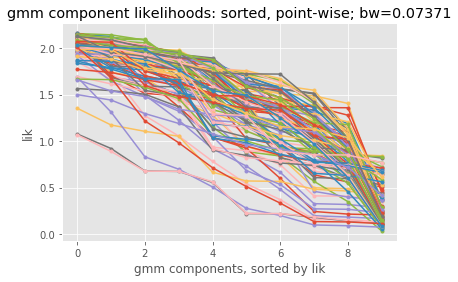

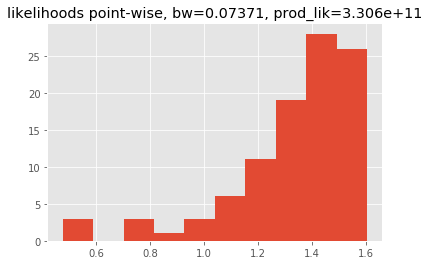

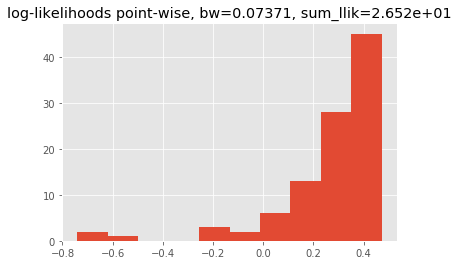

prod_liks=3.306e+11, log_prod_lik=2.652e+01, sum_llik=2.652e+01




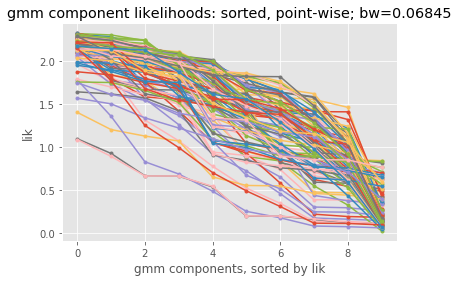

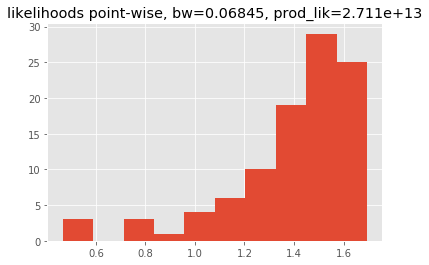

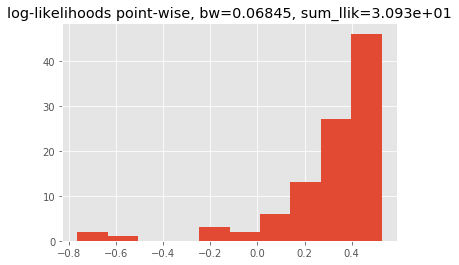

prod_liks=2.711e+13, log_prod_lik=3.093e+01, sum_llik=3.093e+01




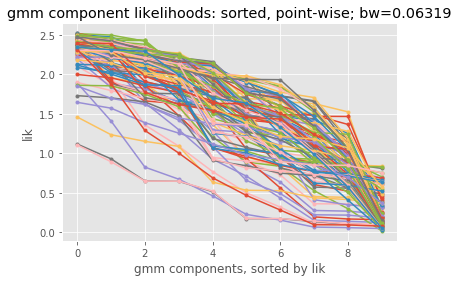

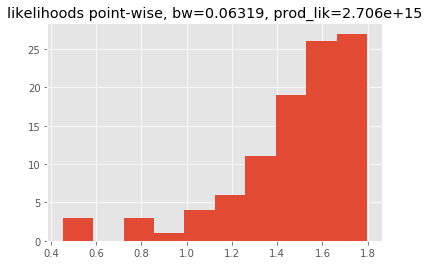

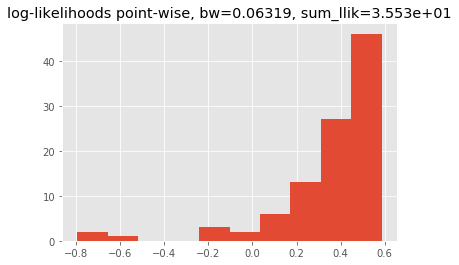

prod_liks=2.706e+15, log_prod_lik=3.553e+01, sum_llik=3.553e+01




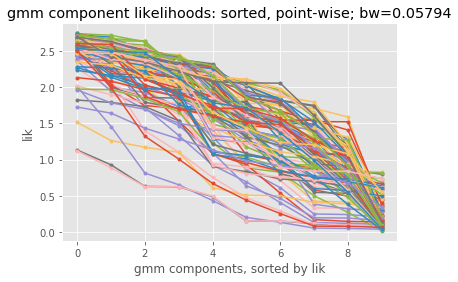

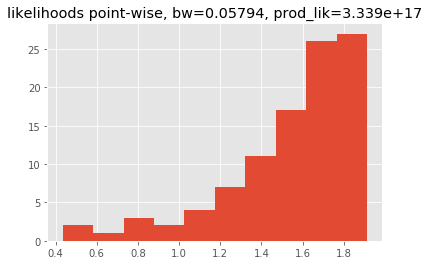

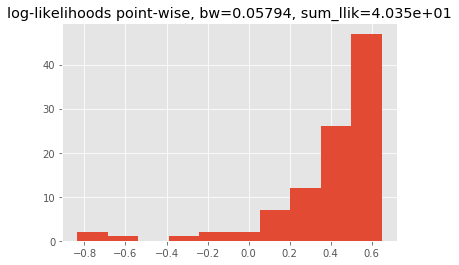

prod_liks=3.339e+17, log_prod_lik=4.035e+01, sum_llik=4.035e+01




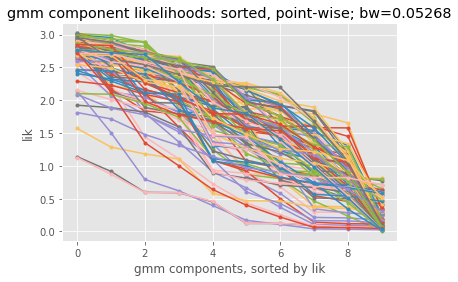

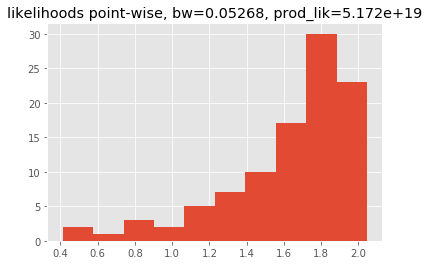

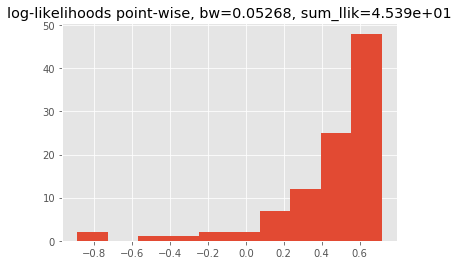

prod_liks=5.172e+19, log_prod_lik=4.539e+01, sum_llik=4.539e+01




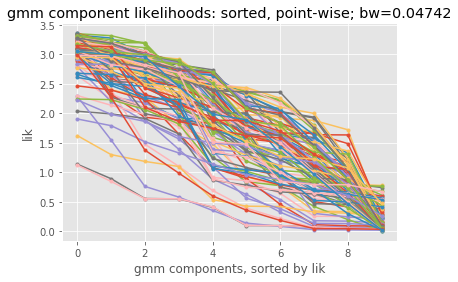

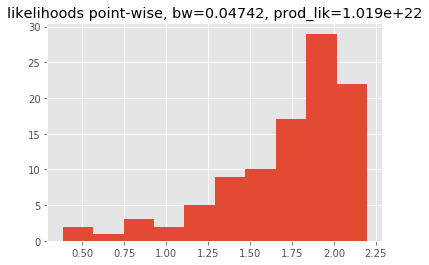

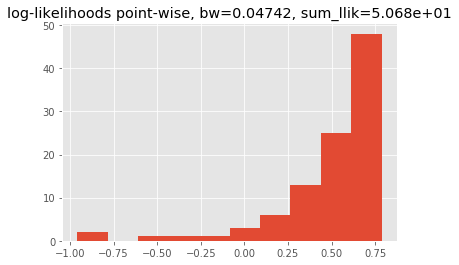

prod_liks=1.019e+22, log_prod_lik=5.068e+01, sum_llik=5.068e+01




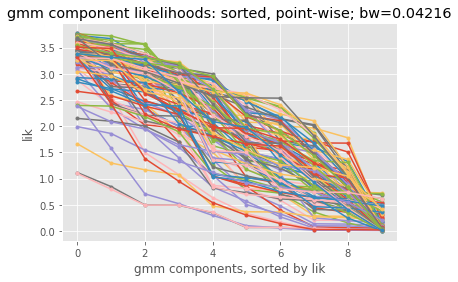

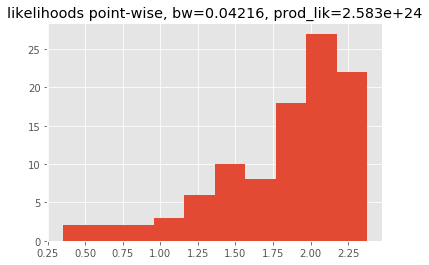

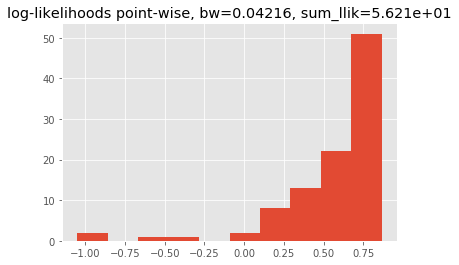

prod_liks=2.583e+24, log_prod_lik=5.621e+01, sum_llik=5.621e+01




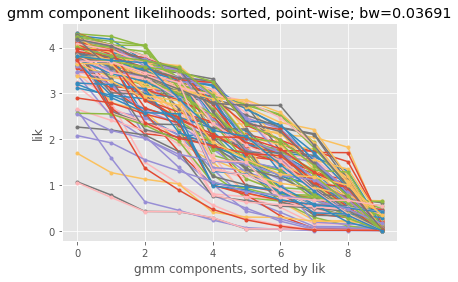

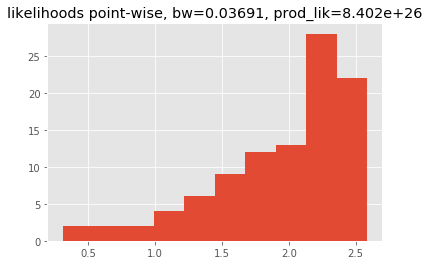

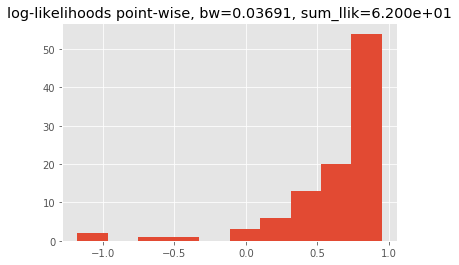

prod_liks=8.402e+26, log_prod_lik=6.200e+01, sum_llik=6.200e+01




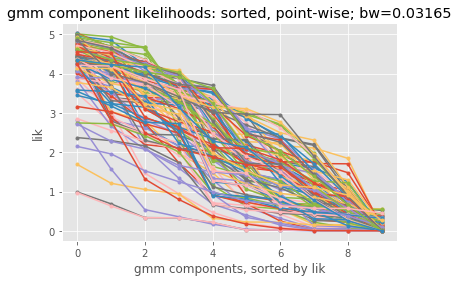

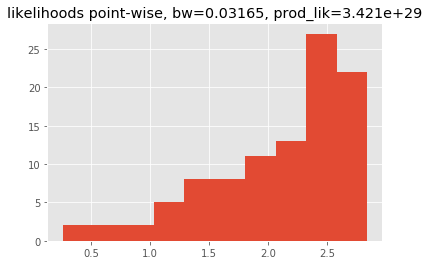

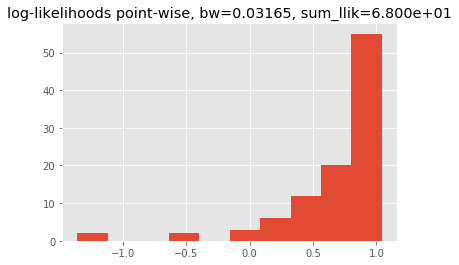

prod_liks=3.421e+29, log_prod_lik=6.800e+01, sum_llik=6.800e+01




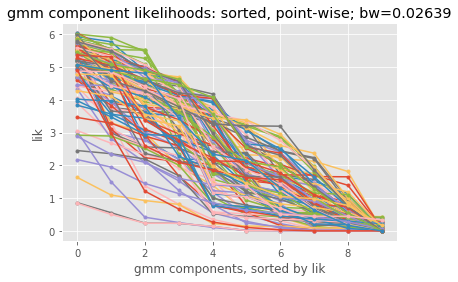

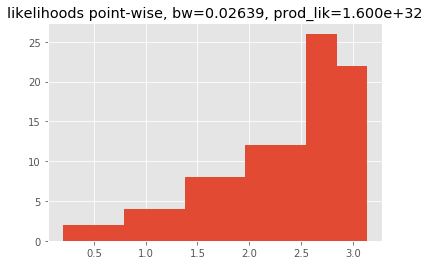

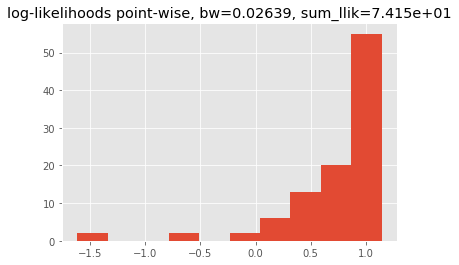

prod_liks=1.600e+32, log_prod_lik=7.415e+01, sum_llik=7.415e+01




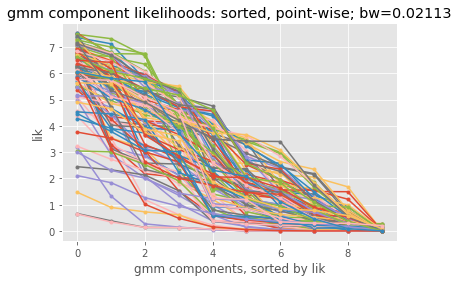

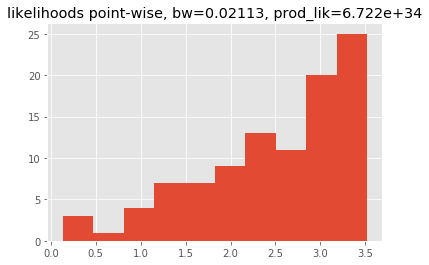

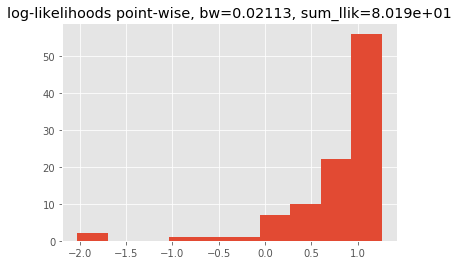

prod_liks=6.722e+34, log_prod_lik=8.019e+01, sum_llik=8.019e+01




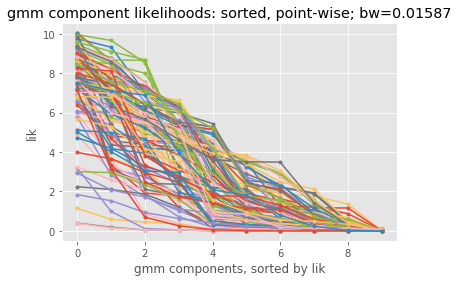

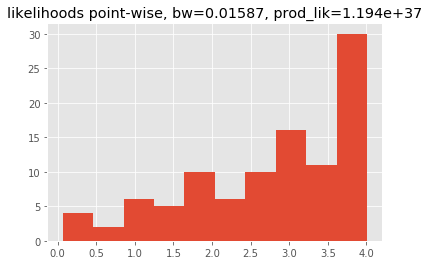

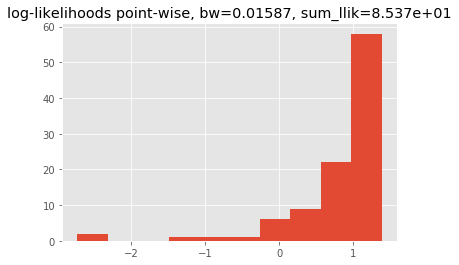

prod_liks=1.194e+37, log_prod_lik=8.537e+01, sum_llik=8.537e+01




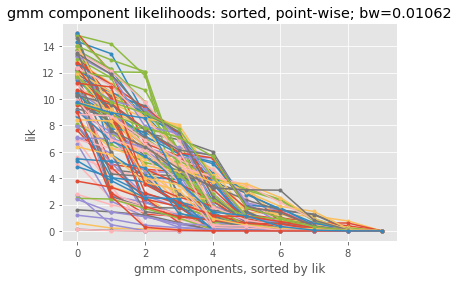

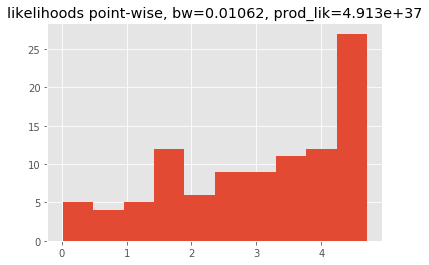

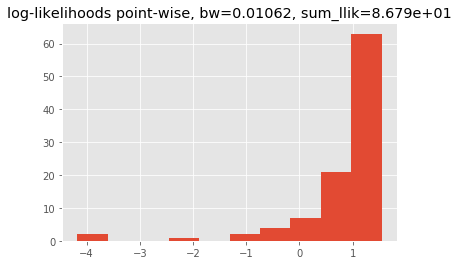

prod_liks=4.913e+37, log_prod_lik=8.679e+01, sum_llik=8.679e+01




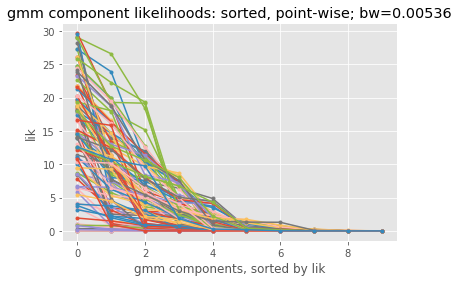

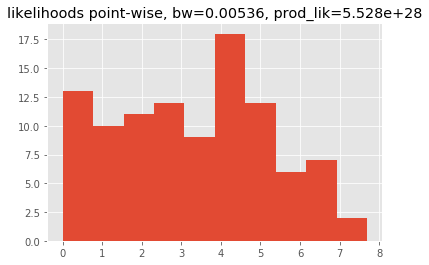

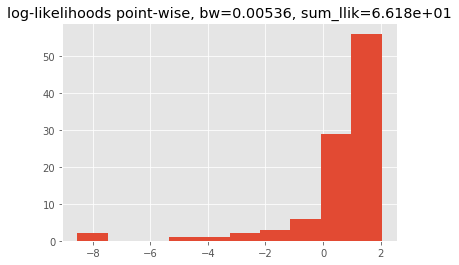

prod_liks=5.528e+28, log_prod_lik=6.618e+01, sum_llik=6.618e+01




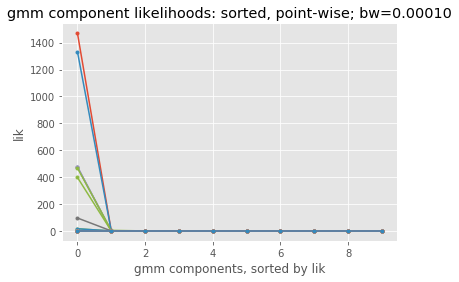

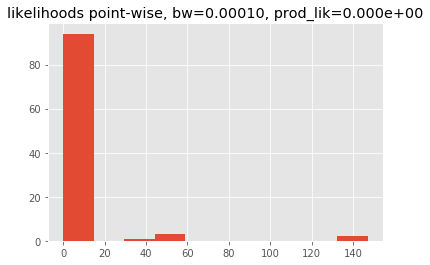

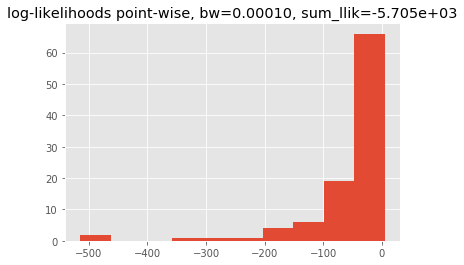

/Users/mauricediesendruck/privacy/mv_sp_privacy/src/sp_utils.py:712: RuntimeWarning: divide by zero encountered in log
  np.prod(liks), np.log(np.prod(liks)), np.sum(lliks)))
/Users/mauricediesendruck/privacy/mv_sp_privacy/src/sp_utils.py:713: RuntimeWarning: divide by zero encountered in log
  if not np.isclose(np.log(prod_liks), sum_lliks):


prod_liks=0.000e+00, log_prod_lik=-inf, sum_llik=-5.705e+03


Check sum_lliks computation
> /Users/mauricediesendruck/privacy/mv_sp_privacy/src/sp_utils.py(727)mixture_model_likelihood()
-> if likelihood == np.Inf:
(Pdb) c
bw: 0.100000, lik: 6.98e+00
bw: 0.094742, lik: 1.06e+01
bw: 0.089484, lik: 1.43e+01
bw: 0.084226, lik: 1.82e+01
bw: 0.078968, lik: 2.23e+01
bw: 0.073711, lik: 2.65e+01
bw: 0.068453, lik: 3.09e+01
bw: 0.063195, lik: 3.55e+01
bw: 0.057937, lik: 4.03e+01
bw: 0.052679, lik: 4.54e+01
bw: 0.047421, lik: 5.07e+01
bw: 0.042163, lik: 5.62e+01
bw: 0.036905, lik: 6.20e+01
bw: 0.031647, lik: 6.80e+01
bw: 0.026389, lik: 7.42e+01
bw: 0.021132, lik: 8.02e+01
bw: 0.015874, lik: 8.54e+01
bw: 0.010616, lik: 8.68e+01
bw: 0.005358, lik: 6.62e+01
bw: 0.000100, lik: -5.71e+03


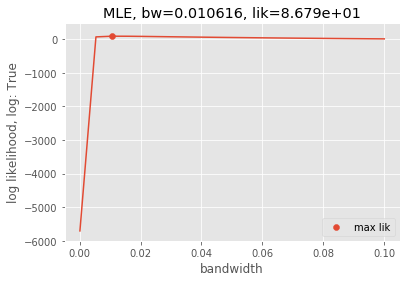

In [ ]:
# Find optimal bandwidth using Maximum Likelihood.
NUM_BANDWIDTHS = 20
BW_HIGH, BW_LOW = 0.1, 0.0001
BW_RANGE = np.linspace(BW_HIGH, BW_LOW, NUM_BANDWIDTHS)
PLOT = 1

# Store bandwidth and likelihood pairs.
bw_lik = np.zeros((NUM_BANDWIDTHS, 2))

# Keep track of MLE and associated bandwidth.
bw_opt_lik = 0
bw_opt = 1e10
bw_worst_lik = 1e100
bw_worst = 0

# Measure data likelihood under models centered on private support
# points, with a range of bandwidths.
for i, bw in enumerate(BW_RANGE):    
    lik, do_log = mixture_model_likelihood(x, y_tilde, bw)

    if lik > bw_opt_lik:
        bw_opt_lik = lik
        bw_opt = bw

    if lik <= bw_worst_lik:
        bw_worst_lik = lik
        bw_worst = bw

    bw_lik[i] = [bw, lik]


# Print and plot all bandwidth-likelihood pairs.
max_bw_lik = bw_lik[np.argmax(bw_lik, axis=0)[1]]

for bw, lik in bw_lik:
    print('bw: {:.6f}, lik: {:.2e}'.format(bw, lik))
plt.plot(bw_lik[:, 0], bw_lik[:, 1])
plt.scatter(*max_bw_lik, label='max lik')
plt.xlabel('bandwidth')
plt.ylabel('log likelihood, log: {}'.format(do_log))
plt.title('MLE, bw={:.6f}, lik={:.3e}'.format(max_bw_lik[0], max_bw_lik[1]))
plt.legend()
plt.show()

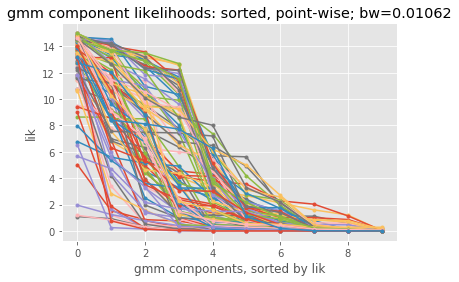

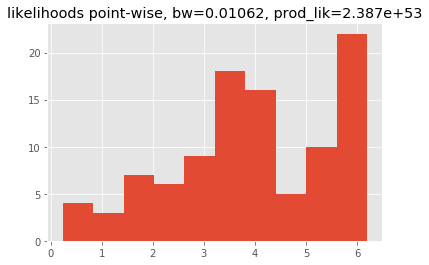

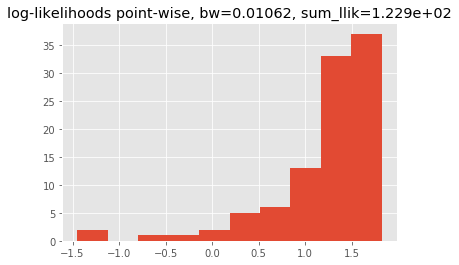

prod_liks=2.387e+53, log_prod_lik=1.229e+02, sum_llik=1.229e+02




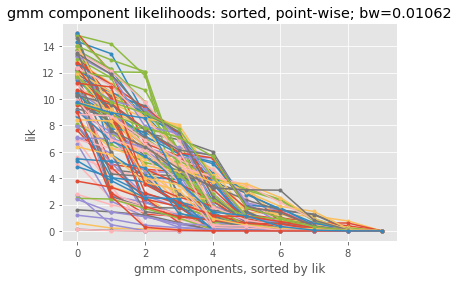

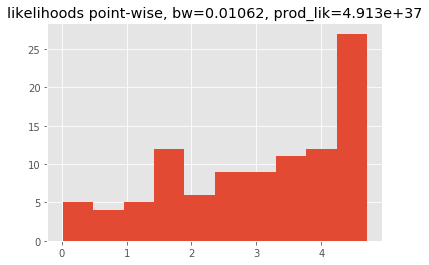

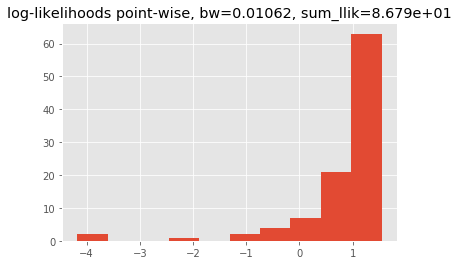

prod_liks=4.913e+37, log_prod_lik=8.679e+01, sum_llik=8.679e+01


do_log: True
P(x | y_opt, bw_opt): 1.23e+02
P(x | y_tilde, bw_opt): 8.68e+01


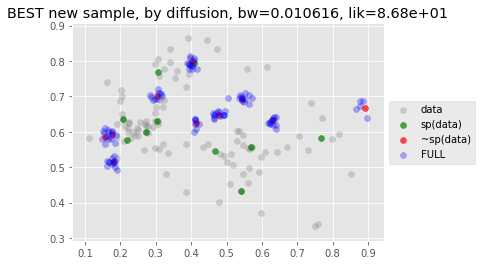

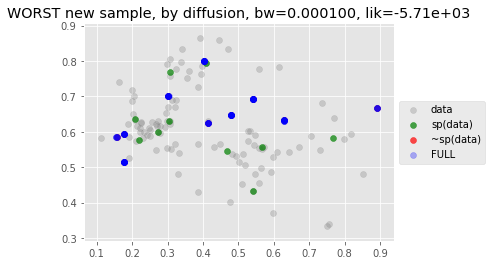

In [ ]:
# Compare to likelihoods of data and optimal support points.
lik_y_opt, _ = mixture_model_likelihood(x, y_opt, bw_opt)
lik_y_tilde, _ = mixture_model_likelihood(x, y_tilde, bw_opt)

print('do_log: {}'.format(do_log))
print('P(x | y_opt, bw_opt): {:.2e}'.format(lik_y_opt))
print('P(x | y_tilde, bw_opt): {:.2e}'.format(lik_y_tilde))


# Plot results.
new_sample = (
    y_tilde_upsampled + np.random.normal(0, bw_opt,
                                         size=(FULL_SAMPLE_SIZE, x.shape[1])))
new_sample_worst = (
    y_tilde_upsampled + np.random.normal(0, bw_worst,
                                         size=(FULL_SAMPLE_SIZE, x.shape[1])))


if PLOT:
    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    #plt.scatter(mus[:, 0], mus[:, 1], c='green', alpha=1, s=700*weights,
    #    label='true centroids')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], c='green', alpha=0.7,
                label='sp(data)')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7,
                label='~sp(data)')
    plt.scatter(new_sample[:, 0], new_sample[:, 1], c='blue', alpha=0.3,
                label='FULL')

    plt.title('BEST new sample, by {}, bw={:.6f}, lik={:.2e}'.format(
        'diffusion', bw_opt, bw_opt_lik))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    #plt.scatter(mus[:, 0], mus[:, 1], c='green', alpha=1, s=700*weights,
    #    label='true centroids')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], c='green', alpha=0.7,
                label='sp(data)')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7,
                label='~sp(data)')
    plt.scatter(new_sample_worst[:, 0], new_sample_worst[:, 1], c='blue',
                alpha=0.3, label='FULL')

    plt.title('WORST new sample, by {}, bw={:.6f}, lik={:.2e}'.format(
        'diffusion', bw_worst, bw_worst_lik))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

____

### 6.2. Try repeated draws of private support points, and concatenate results.

In [ ]:
NUM_REPEATS = int(M / N) + 1
new_sample = []
STEP_SIZE = 1e-2

#print('NOTE: CHANGED ALPHA!')
#ALPHA = NUM_REPEATS * ALPHA

for i in range(NUM_REPEATS):
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion,
     energy_y_y_tilde) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
                                                      x, y_opt, STEP_SIZE,
                                                      ALPHA / float(NUM_REPEATS),
                                                      BANDWIDTH, FULL_SAMPLE_SIZE)
    new_sample.append(y_tilde)

print('\nConcatenating results, and plotting collection of samples as one.\n')

new_sample = np.concatenate(new_sample)

plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
# plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7, label='~sp(data)')
plt.scatter(new_sample[:, 0], new_sample[:, 1], c='red', alpha=0.3, label='FULL')

plt.title('{}, alpha={:.3f}, repeats={}, n={}, budget={}'.format(
    METHOD, ALPHA / float(NUM_REPEATS), NUM_REPEATS, len(new_sample), ALPHA))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlim(0, 1)
#plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.5374 / 0.909) = Exp(1.1823)



### 6.3 Use DP sample of median of pairwise distances as bandwidth.
Choose W based on data (median heuristics). Add DP noise to W, i.e. add $\eta \sim \mbox{Lap}(2^{(1/p)} / 2)$. Get SP with MMD_W. Do KDE with W.

In [ ]:
if 0:
    # Show data and y_tilde.
    NUM_Y_TILDES = 1
    METHOD = 'diffusion'
    SAMPLE_SIZE = M
    STEP_SIZE = 2e-3

    # Compute median of pairwise distanes, and use that as bandwidth.
    median_pairwise_dists = np.median(pdist(x, 'minkowski', p=ENERGY_POWER))
    sensitivity_median_pairwise_dists = DIM ** (1. / ENERGY_POWER) / 2.
    private_median = median_pairwise_dists + np.random.laplace(
        scale=sensitivity_median_pairwise_dists / ALPHA)
    print(median_pairwise_dists)
    print(private_median)
    #pdb.set_trace()

    """
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion,
     energy_y_y_tilde) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
                                                      x, y_opt, STEP_SIZE, ALPHA,
                                                      private_median, SAMPLE_SIZE)

    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7, label='~sp(data)')
    plt.scatter(y_tilde_expansion[:, 0], y_tilde_expansion[:, 1], c='blue', 
                alpha=0.3, label='FULL')

    plt.title('{}, and PRE-SELECTED w = {}'.format(METHOD, BANDWIDTH))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    """

# End.